In [1]:
import os
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl

from linear_hierarchical_model import *

#Matplotlib options to get Times face and LaTeX for the paper.
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']

prior_colors=('#bcd5e7','C0')
posterior_colors=('#c7a5d6', '#8119b5')

topdir='results/linear_model/'
if not os.path.exists(topdir): os.makedirs(topdir)

This notebook contains investigations associated with the linear model problem described in the SAND report *Theoretical and methodological challenges in hierarchical Bayesian inference for model-form uncertainty*.

We consider a problem where the data-generating process is a nonlinear function of independent variable $x$:
$$
y_{true} = 3 x^\alpha
$$
and the mathematical model is assumed a linear function of $x$:
$$
m(\theta) = \theta x.
$$
For this simple problem we treat the entire governing equation as uncertain through a hyperparameterization of the slope parameter $\theta$. 
We assume $\theta\sim\mathcal{N}(\mu,\sigma^2)$, where $\mu$ is assumed normally distributed and $\sigma$ is assumed exponentially distributed.

The likelihood is assumed to be
$$
d = m(\theta) + \epsilon_m, \quad \epsilon_m \sim \mathcal{N}(0, 0.1^2).
$$

### First example

In this first example, we illustrate two things. First, posing the problem hierarchically doesn't save you. You can end up with overconfident posteriors anyway. Also, the scale parameter isn't updated. This is something we observe a lot in practice.

In [10]:
figdir = f'{topdir}/example_1/'
if not os.path.exists(figdir): os.makedirs(figdir)

100%|██████████| 10000/10000 [00:26<00:00, 383.11it/s]


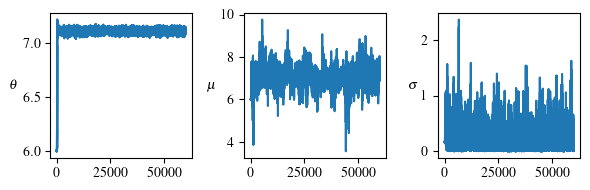

In [11]:
mu_mean1 = 6
mu_std1 = 3
sigma_l1 = 6
lhm1 = LinearHierarchicalModel(m_mu=mu_mean1, m_s=mu_std1, s_lam=sigma_l1)

lhm1.run_mcmc(10000)
lhm1.plot_chains(lhm1.get_chains())

Getting rid of burn-in...

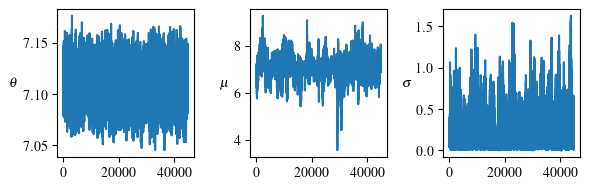

In [12]:
post_samples1 = lhm1.get_chains()[15000:]
lhm1.plot_chains(post_samples1)
hyperparam_posts1 = post_samples1[:,1:]

First we plot the prior vs posterior marginals

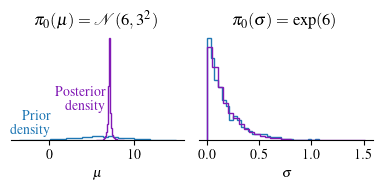

In [17]:
np.random.seed(20250807)
prior_samples = lhm1.get_prior_samples()

fig = plt.figure(figsize=(4,2))
axs = fig.subplots(1,2)

ax = axs[0]
ax.set_title(rf'$\pi_0(\mu)=\mathcal{{N}}({{{mu_mean1}}},{{{mu_std1}}}^2)$')
ax.hist(prior_samples[:,0], histtype='step', density=True, color=prior_colors[1], bins=30);
ax.hist(hyperparam_posts1[:,0], histtype='step', density=True, color=posterior_colors[1], bins=30);
ax.set_xlabel(r'$\mu$')

ax.annotate('Prior\ndensity', (0.1, 0.1), ha='right', va='bottom', color=prior_colors[1])
ax.annotate('Posterior\ndensity', (6.5, 1), ha='right', va='bottom', color=posterior_colors[1])

ax = axs[1]
ax.set_title(rf'$\pi_0(\sigma)=\exp({{{sigma_l1}}})$')
ax.hist(prior_samples[:,1], histtype='step', density=True, color=prior_colors[1], bins=30);
ax.hist(hyperparam_posts1[:,1], histtype='step', density=True, color=posterior_colors[1], bins=30);
ax.set_xlabel(r'$\sigma$')

for ax in axs:
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)

fig.tight_layout()
fig.savefig(f'{figdir}/hyperparam_marginals.pdf', bbox_inches='tight')

The scale parameter hasn't been updated at all, only the mean. 

Now let's consider the pushforwards

In [18]:
prpfs = lhm1.get_predictive_samples(prior_samples)
ppfs = lhm1.get_predictive_samples(hyperparam_posts1)

prp_q5, prp_q95 = np.quantile(prpfs, q=(0.025, 0.975), axis=0)
pp_q5, pp_q95 = np.quantile(ppfs, q=(0.025, 0.975), axis=0)

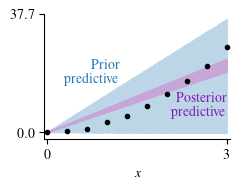

In [19]:
fig = plt.figure(figsize=(2.5,2))
ax = fig.add_subplot(111)

ax.fill_between(lhm1.x, prp_q5, prp_q95, color=prior_colors[0])
ax.fill_between(lhm1.x, pp_q5, pp_q95, color=posterior_colors[0])
ax.plot(lhm1.x_dat, lhm1.y, 'k.')

ax.annotate('Prior\npredictive', (1.2,15), ha='right', va='bottom', color=prior_colors[1])
ax.annotate('Posterior\npredictive', (2.98,13), ha='right', va='top', color=posterior_colors[1])
ax.set_xlabel(r'$x$')
ax.set_xticks([0,3])
ax.set_xlim([-.05,3.05])
ax.spines[['top','right']].set_visible(False)
ax.set_yticks([0,ax.get_ylim()[-1]])

fig.tight_layout()
fig.savefig(f'{figdir}/pushforwards.pdf', bbox_inches='tight')


### Example 2

Scale parameters aren't informed except for really degenerate cases

In [8]:
figdir = f'{topdir}/example_2/'
if not os.path.exists(figdir): os.makedirs(figdir)

Here we pose a $\mu$ hyperprior that is pretty wrong and also pretty confident, so that the mean posterior can't really budget. 
Then in that case, the standard deviation actually has to update.

100%|██████████| 10000/10000 [00:23<00:00, 424.69it/s]


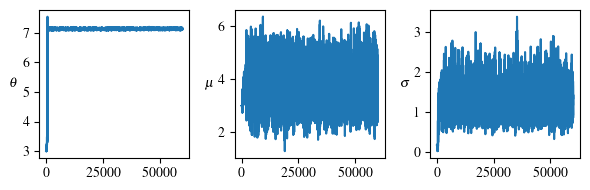

In [9]:
mu_mean = 3
mu_std = 0.6
sigma_l = 6
lhm = LinearHierarchicalModel(m_mu=mu_mean, m_s=mu_std, s_lam=sigma_l)

lhm.run_mcmc(10000)
lhm.plot_chains(lhm.get_chains())

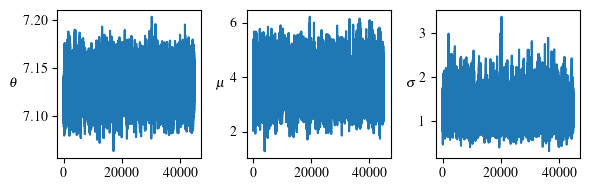

In [10]:
post_samples = lhm.get_chains()[15000:]
lhm.plot_chains(post_samples)
hyperparam_posts = post_samples[:,1:]

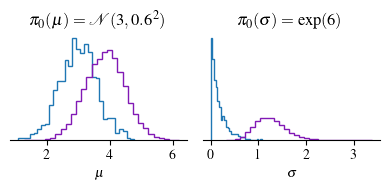

In [11]:
np.random.seed(20250807)
prior_samples = lhm.get_prior_samples()

fig = plt.figure(figsize=(4,2))
axs = fig.subplots(1,2)

ax = axs[0]
ax.set_title(rf'$\pi_0(\mu)=\mathcal{{N}}({{{mu_mean}}},{{{mu_std}}}^2)$')
ax.hist(prior_samples[:,0], histtype='step', density=True, color=prior_colors[1], bins=30);
ax.hist(hyperparam_posts[:,0], histtype='step', density=True, color=posterior_colors[1], bins=30);
ax.set_xlabel(r'$\mu$')

ax.annotate('Prior\ndensity', (0.1, 0.1), ha='right', va='bottom', color=prior_colors[1])
ax.annotate('Posterior\ndensity', (6.5, 1), ha='right', va='bottom', color=posterior_colors[1])

ax = axs[1]
ax.set_title(rf'$\pi_0(\sigma)=\exp({{{sigma_l}}})$')
ax.hist(prior_samples[:,1], histtype='step', density=True, color=prior_colors[1], bins=30);
ax.hist(hyperparam_posts[:,1], histtype='step', density=True, color=posterior_colors[1], bins=30);
ax.set_xlabel(r'$\sigma$')

for ax in axs:
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)

fig.tight_layout()
fig.savefig(f'{figdir}/hyperparam_marginals.pdf', bbox_inches='tight')

In [12]:
prpfs = lhm.get_predictive_samples(prior_samples)
ppfs = lhm.get_predictive_samples(hyperparam_posts)

prp_q5, prp_q95 = np.quantile(prpfs, q=(0.025, 0.975), axis=0)
pp_q5, pp_q95 = np.quantile(ppfs, q=(0.025, 0.975), axis=0)

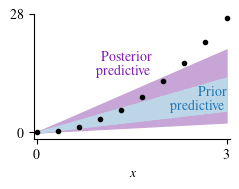

In [13]:
fig = plt.figure(figsize=(2.5,2))
ax = fig.add_subplot(111)

ax.fill_between(lhm.x, pp_q5, pp_q95, color=posterior_colors[0])
ax.fill_between(lhm.x, prp_q5, prp_q95, color=prior_colors[0])
#ax.fill_between(lhm.x, pp_q5, pp_q95, color=posterior_colors[0])
ax.plot(lhm.x_dat, lhm.y, 'k.')

ax.annotate('Posterior\npredictive', (1.8,13), ha='right', va='bottom', color=posterior_colors[1])
ax.annotate('Prior\npredictive', (2.98,11), ha='right', va='top', color=prior_colors[1])
ax.set_xlabel(r'$x$')
ax.set_xticks([0,3])
ax.set_xlim([-.05,3.05])
ax.spines[['top','right']].set_visible(False)
ax.set_ylim([ax.get_ylim()[0],28])
ax.set_yticks([0,ax.get_ylim()[-1]])

fig.tight_layout()
fig.savefig(f'{figdir}/pushforwards.pdf', bbox_inches='tight')

In [14]:
lhm.get_MLE()

array([7.13188404])

**TODO** do we need to be able to speak to what theta is doing during calibration to make these results make sense?

### Example 3

Same prior pushforward, drastically different posterior

In [15]:
figdir = f'{topdir}/example_3/'
if not os.path.exists(figdir): os.makedirs(figdir)

This case is the same as example 1 so we can just copy/paste that code here.

100%|██████████| 10000/10000 [00:23<00:00, 423.78it/s]


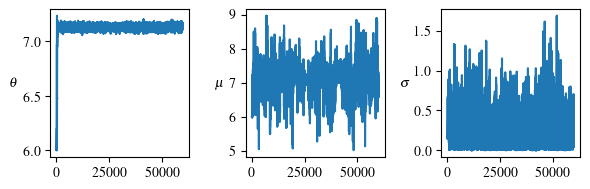

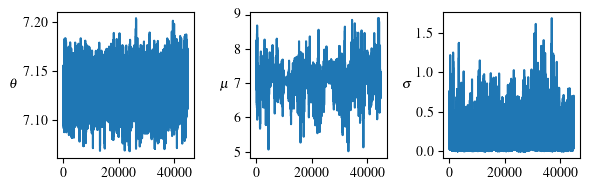

In [16]:
mu_mean1 = 6
mu_std1 = 3
sigma_l1 = 6
lhm1 = LinearHierarchicalModel(m_mu=mu_mean1, m_s=mu_std1, s_lam=sigma_l1)

lhm1.run_mcmc(10000)
lhm1.plot_chains(lhm1.get_chains())
post_samples1 = lhm1.get_chains()[15000:]
lhm1.plot_chains(post_samples1)
hyperparam_posts1 = post_samples1[:,1:]

100%|██████████| 10000/10000 [00:23<00:00, 427.94it/s]


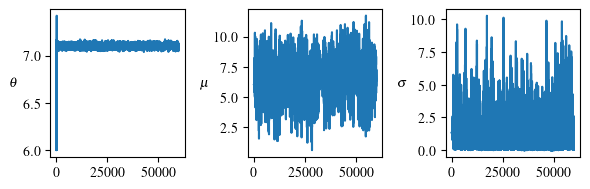

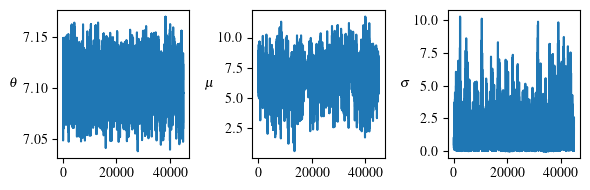

In [17]:
mu_mean2 = 6
mu_std2 = 2
sigma_l2 = 0.75
lhm2 = LinearHierarchicalModel(m_mu=mu_mean2, m_s=mu_std2, s_lam=sigma_l2)

lhm2.run_mcmc(10000)
lhm2.plot_chains(lhm2.get_chains())
post_samples2 = lhm2.get_chains()[15000:]
lhm2.plot_chains(post_samples2)
hyperparam_posts2 = post_samples2[:,1:]

In [18]:
theta_post_samples1 = lhm1.get_theta_samples(hyperparam_posts1)
theta_post_samples2 = lhm2.get_theta_samples(hyperparam_posts2)

In [19]:
np.random.seed(20250807)
prior_samples1 = lhm1.get_prior_samples()
theta_prior_samples1 = lhm1.get_theta_samples(prior_samples1)
prior_samples2 = lhm2.get_prior_samples()
theta_prior_samples2 = lhm2.get_theta_samples(prior_samples2)

In [20]:
prpfs1 = lhm1.get_predictive_samples(prior_samples1)
ppfs1 = lhm1.get_predictive_samples(hyperparam_posts1)

prp1_q5, prp1_q95 = np.quantile(prpfs1, q=(0.025, 0.975), axis=0)
pp1_q5, pp1_q95 = np.quantile(ppfs1, q=(0.025, 0.975), axis=0)

In [21]:
prpfs2 = lhm2.get_predictive_samples(prior_samples2)
ppfs2 = lhm2.get_predictive_samples(hyperparam_posts2)

prp2_q5, prp2_q95 = np.quantile(prpfs2, q=(0.025, 0.975), axis=0)
pp2_q5, pp2_q95 = np.quantile(ppfs2, q=(0.025, 0.975), axis=0)

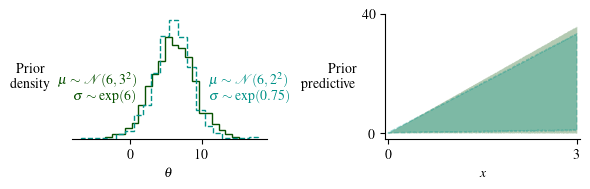

In [22]:
color1 = "#075100"
color2 = "#009288"

fig = plt.figure(figsize=(6,2))
axs = fig.subplots(1,2)

ax = axs[0]
ax.hist(theta_prior_samples1, histtype='step', density=True, bins=20, color=color1);
ax.annotate(rf'$\mu\sim\mathcal{{N}}({mu_mean1}, {mu_std1}^2)$'+'\n'+rf'$\sigma\sim\exp({sigma_l1})$', (1,0.05), ha='right', va='bottom', color=color1);

ax.hist(theta_prior_samples2, histtype='step', density=True, bins=20, color=color2, linestyle='--');
ax.annotate(rf'$\mu\sim\mathcal{{N}}({mu_mean2}, {mu_std2}^2)$'+'\n'+rf'$\sigma\sim\exp({sigma_l2})$', (11,0.05), ha='left', va='bottom', color=color2);
ax.set_xlabel(r'$\theta$')

ax.set_ylabel('Prior\ndensity', rotation=0, ha='center', va='center', labelpad=30)
ax.set_yticks([])
ax.spines[['top','right','left']].set_visible(False)

ax = axs[1]
ax.fill_between(lhm1.x, prp1_q5, prp1_q95, color=color1, alpha=0.3, linewidth=0 )
ax.fill_between(lhm2.x, prp2_q5, prp2_q95, color=color2, alpha=0.3, linestyles='--' )
ax.spines[['top','right']].set_visible(False)
ax.set_yticks([0,ax.get_yticks()[-1]])
ax.set_xlabel(r'$x$')
ax.set_xticks([0,3])
ax.set_xlim([-.05,3.05])
ax.set_ylabel('Prior\npredictive', rotation=0, ha='right', va='center')

fig.tight_layout()
fig.savefig(f'{figdir}/prior_compare.pdf', bbox_inches='tight')

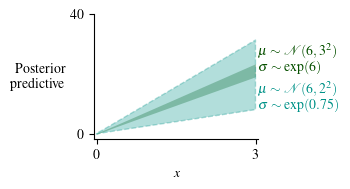

In [23]:
fig = plt.figure(figsize=(3.6,2))
ax = fig.add_subplot(111)

ax.fill_between(lhm1.x, pp1_q5, pp1_q95, color=color1, alpha=0.3, linewidth=0 )
ax.fill_between(lhm2.x, pp2_q5, pp2_q95, color=color2, alpha=0.3, linestyles='--' )
ax.annotate(rf'$\mu\sim\mathcal{{N}}({mu_mean1}, {mu_std1}^2)$'+'\n'+rf'$\sigma\sim\exp({sigma_l1})$', (3.05, 25), ha='left', va='center', color=color1);
ax.annotate(rf'$\mu\sim\mathcal{{N}}({mu_mean2}, {mu_std2}^2)$'+'\n'+rf'$\sigma\sim\exp({sigma_l2})$', (3.05,12.5), ha='left', va='center', color=color2);
ax.spines[['top','right']].set_visible(False)
ax.set_yticks([0,ax.get_yticks()[-1]])
ax.set_xlabel(r'$x$')
ax.set_xticks([0,3])
ax.set_xlim([-.05,3.05])
ax.set_ylabel('Posterior\npredictive', rotation=0, ha='right', va='center')
fig.tight_layout()
fig.savefig(f'{figdir}/posterior_compare.pdf', bbox_inches='tight')

### Example 4
Uncertainty doesn't increase as model discrepancy increases.

In [24]:
figdir = f'{topdir}/example_4/'
if not os.path.exists(figdir): os.makedirs(figdir)

100%|██████████| 10000/10000 [00:23<00:00, 429.54it/s]


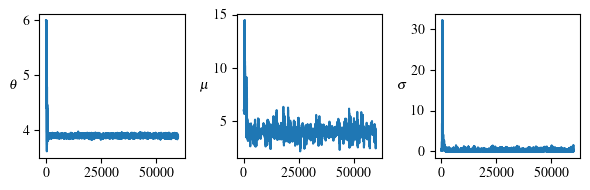

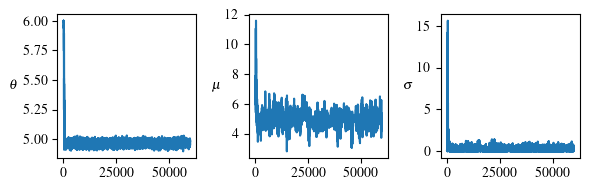

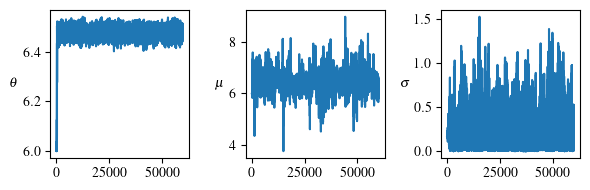

In [25]:
mu_mean = 6
mu_std = 3
sigma_l = 6
alphas = [1.3, 1.6, 1.9]
lhms = [ LinearHierarchicalModel(m_mu=mu_mean, m_s=mu_std, s_lam=sigma_l, dat_expon=alpha) for alpha in alphas]

for lhm in lhms:
    lhm.run_mcmc(10000)
    lhm.plot_chains(lhm.get_chains())

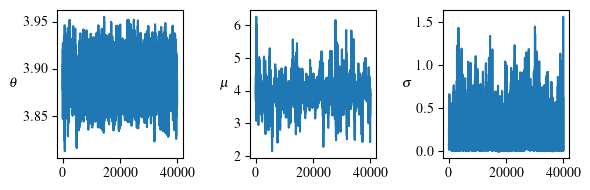

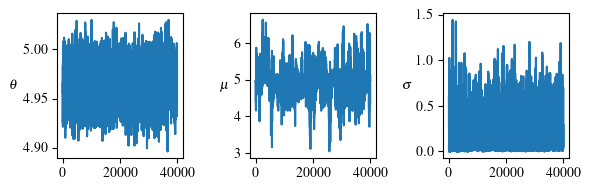

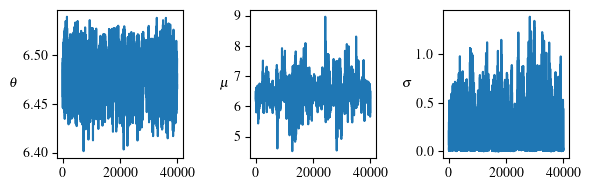

In [26]:
post_samples = [ lhm.get_chains()[20000:] for lhm in lhms ]
hyperparam_posts = [ ps[:,1:] for ps in post_samples ]
for lhm, ps in zip(lhms, post_samples):
    lhm.plot_chains(ps)

In [27]:
np.random.seed(20250807)
prior_samples = lhms[0].get_prior_samples()

In [28]:
prpfs = lhms[0].get_predictive_samples(prior_samples)
ppfs = [ lhm.get_predictive_samples(hp) for lhm, hp in zip(lhms,hyperparam_posts) ]

prp_q5, prp_q95 = np.quantile(prpfs, q=(0.025, 0.975), axis=0)

pps_q5 = [ np.quantile(ppf, q=0.025, axis=0) for ppf in ppfs ]
pps_q95 = [ np.quantile(ppf, q=0.975, axis=0) for ppf in ppfs ]

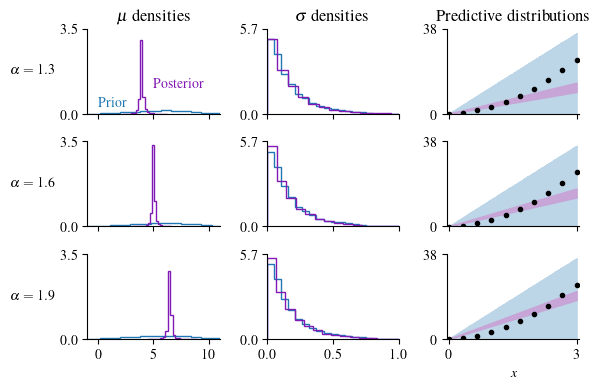

In [29]:
fig = plt.figure(figsize=(6,4))
axs = fig.subplots(3,3, sharex='col', sharey='col')

nbin = 20
for i, (hp, alpha, pp_q5, pp_q95) in enumerate(zip(hyperparam_posts, alphas, pps_q5, pps_q95)):
    axs[i,0].set_ylabel(rf'$\alpha={alpha}$', rotation=0, ha='right', va='center')
    axs[i,0].hist(prior_samples[:,0], histtype='step', density=True, color=prior_colors[1], bins=nbin);
    axs[i,0].hist(hp[:,0], histtype='step', density=True, color=posterior_colors[1], bins=nbin);

    axs[i,1].hist(prior_samples[:,1], histtype='step', density=True, color=prior_colors[1], bins=nbin);
    axs[i,1].hist(hp[:,1], histtype='step', density=True, color=posterior_colors[1], bins=nbin);

    axs[i,2].fill_between(lhm.x, prp_q5, prp_q95, color=prior_colors[0])
    axs[i,2].fill_between(lhm.x, pp_q5, pp_q95, color=posterior_colors[0])
    axs[i,2].plot(lhm.x_dat, lhm.y, 'k.')

axs[-1,2].spines[['top','right']].set_visible(False)
axs[-1,2].set_xlabel(r'$x$')
axs[-1,2].set_xticks([0,3])
axs[-1,2].set_xlim([-.05,3.05])

for ax in axs[0,:2]:
    ax.set_ylim([0,np.round(ax.get_ylim()[-1],1)])
    ax.set_yticks([0, ax.get_ylim()[-1]])

axs[0,-1].set_ylim([0,np.round(axs[0,-1].get_ylim()[-1])])
axs[0,-1].set_yticks([0, axs[0,-1].get_ylim()[-1]])

axs[0,0].set_xlim([-1,11])
axs[0,0].set_title(r'$\mu$ densities')
axs[0,1].set_title(r'$\sigma$ densities')
axs[0,2].set_title('Predictive distributions')
for ax in axs.flatten():
    ax.spines[['top','right']].set_visible(False)

axs[0,1].set_xlim([0,1])
axs[0,0].annotate('Prior', (2.5, 0.2), ha='right', va='bottom', color=prior_colors[1])
axs[0,0].annotate('Posterior', (5,1), ha='left', va='bottom', color=posterior_colors[1])

fig.tight_layout()
fig.savefig(f'{figdir}/distribution_compare.pdf', bbox_inches='tight')